# Dacon X LG Aimers

- [스마트 공장 제품 품질 상태 분류 AI 온라인 해커톤](https://dacon.io/competitions/official/236055/overview/description)


- **배경**
    - 펜데믹을 맞이한 최근 몇 년간 제조 운영 및 공급망의 디지털 혁신의 관심도 증가
    - 스마트 공장은 공정 데이터에서 인사이트를 발굴하고, 해석하여 추세를 예측 및 스마트 제조 워크플로와 자동화된 프로세스 구현
    - 품질 편차를 최소화 하여 생산 경제성과 안정성을 확보할 수 있도록 생산된 제품의 품질을 판단 및 분류하는 AI 모델 개발


- **주제 및 설명**
    - 스마트 공장의 제어 시스템 구축을 위한 제품 품질 분류 AI 모델 개발
    - 실제 스마트 공장 데이터를 기반으로 제품의 품질 상태를 분류하는 AI 모델 개발
    
    
- **평가 방식**
    - 평가 산식은 Macro F1 Score
    - LG Aimers 수료 조건은 Baseline 코드의 Public Score (0.55) 초과
    - 1차 평가는 리더보드 Private Score 100%
    - 2차 평가는 오프라인 해커톤 진출을 희망하는 팀은 코드 제출 후 코드 평가
        - Private 상위 30개 팀은 코드 및 PPT 필수 제출
        - 코드 평가를 통과한 Private 상위 30개 팀은 오프라인 해커톤 진출
    - 외부 데이터는 사용 금지
    - 논문으로 공개된 베이스의 사전 학습 모델 (Pre-trained Model) 사용 가능

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 8

## 1. 데이터 불러오기

In [296]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'train: {train.shape}')
train.head()

train: (598, 2881)


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [297]:
print(f'test: {test.shape}')
test.head()

test: (310, 2879)


,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- train 데이터: (598, 2881)
- test 데이터: (310, 2879) -> target 변수인 Y_Class, Y_Quality 변수 없음


- `PRODUCT_ID`: 제품의 고유 ID
- `Y_Class`: 제품의 품질 상태 (Target 변수) -> 0은 적정 기준 미달 (부적합), 1은 적합, 2는 적정 기준 초과 (부적합)
- `Y_Quality`: 제품 품질 관련 정량적 수치
- `TIMESTAMP`: 제품이 공정에 들어간 시간
- `LINE`: 제품이 들어간 공정 LINE 종류 (unique 한 값이 6개)
- `PRODUCT_CODE`: 제품의 CODE 번호 (unique 한 값이 3개)
- `X_1 ~ X_2875`: 공정 과정에서 추출되어 비식별화 된 변수

## 2. 데이터 확인

- train과 test 데이터의 PRODUCT_ID, LINE, PRODUCT_CODE 칼럼 확인 (unique 값, NaN 등)
- train 데이터의 절반 이상이 정상품 (Y_Class = 1)이고, 정상 및 비정상 여부에 따라 Y_Quality 값의 분포를 확인
    - 정상품은 Y_Quality의 값이 0.52와 0.54 사이에 주로 분포하고 있고, 비정상품은 그 분포가 더 넓게 퍼져 있음
- X_1부터 X_2875까지 비식별화 된 변수들의 데이터를 확인해보니, NaN이 많이 있음

In [14]:
# 모든 데이터의 PRODUCT_ID는 unique
len(train['PRODUCT_ID'].unique()), len(test['PRODUCT_ID'].unique())

(598, 310)

In [40]:
# train과 test 데이터의 unique한 LINE은 모두 6개고, 동일
print(f"train 데이터의 LINE: {sorted(train['LINE'].unique())}")
print(f"test 데이터의 LINE:  {sorted(test['LINE'].unique())}")

train 데이터의 LINE: ['T010305', 'T010306', 'T050304', 'T050307', 'T100304', 'T100306']
test 데이터의 LINE:  ['T010305', 'T010306', 'T050304', 'T050307', 'T100304', 'T100306']


In [41]:
# train과 test 데이터의 unique한 PRODUCT_CODE은 모두 3개고, 동일
print(f"train 데이터의 PRODUCT_CODE: {sorted(train['PRODUCT_CODE'].unique())}")
print(f"test 데이터의 PRODUCT_CODE:  {sorted(test['PRODUCT_CODE'].unique())}")

train 데이터의 PRODUCT_CODE: ['A_31', 'O_31', 'T_31']
test 데이터의 PRODUCT_CODE:  ['A_31', 'O_31', 'T_31']


In [239]:
# 정상 및 비정상 제품에 대한 비율과 Y_Quality에 대한 통계값 확인
train.groupby('Y_Class')['Y_Quality'].describe()

,count,mean,std,min,25%,50%,75%,max
Y_Class,,,,,,,,
0,88.0,0.520837,0.004603,0.500856,0.519440,0.522054,0.524113,0.525067
1,407.0,0.530253,0.002444,0.525086,0.528378,0.530308,0.532129,0.534843
2,103.0,0.542031,0.008038,0.534951,0.536354,0.538508,0.546555,0.578841


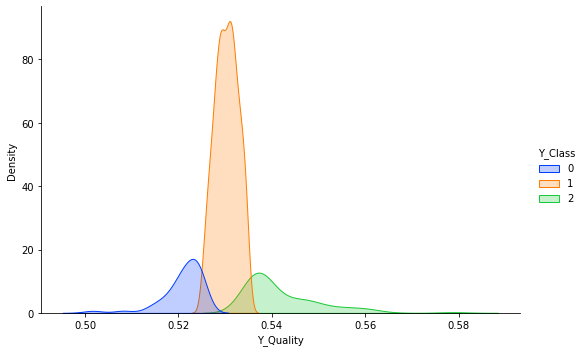

In [273]:
# 정상품 (Y_Class = 1)은 Y_Quality의 값이 0.52와 0.54 사이에 주로 분포하고 있음
sns.displot(
    data=train, x='Y_Quality', hue='Y_Class', kind='kde', 
    fill=True, palette=sns.color_palette('bright')[:3], height=5, aspect=1.5
); plt.show()

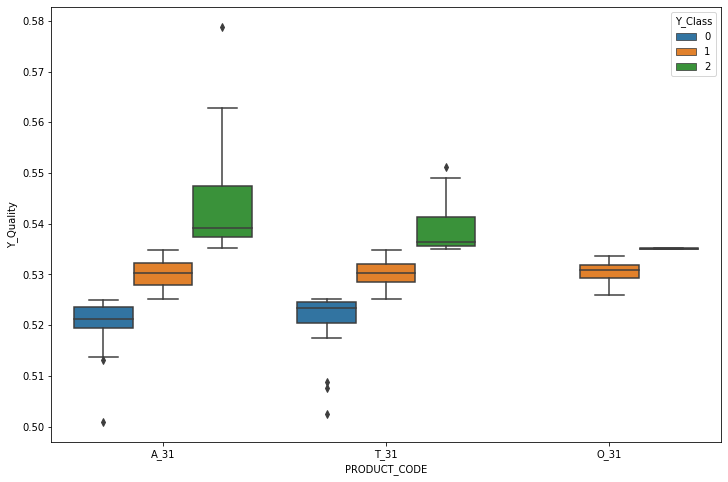

In [279]:
# PRODUCT_CODE에 따라 Y_Class 별로 Y_Quality 값을 boxplot으로 확인
sns.boxplot(
    data=train, x='PRODUCT_CODE', y='Y_Quality', hue='Y_Class'
); plt.show()

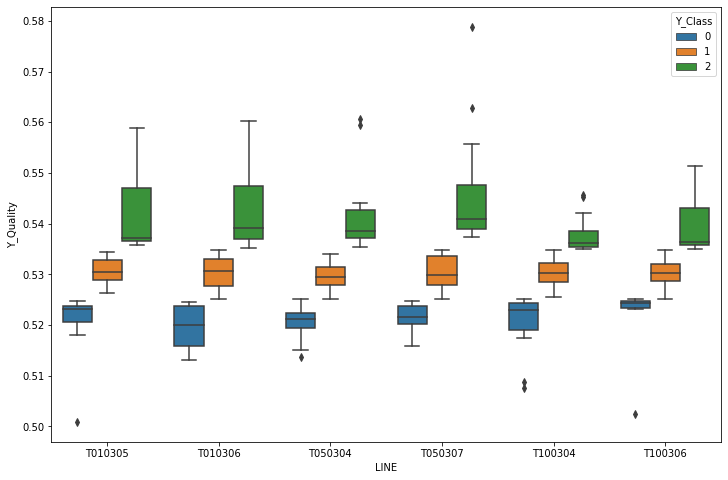

In [280]:
# LINE에 따라 Y_Class 별로 Y_Quality 값을 boxplot으로 확인
sns.boxplot(
    data=train.sort_values('LINE'), x='LINE', y='Y_Quality', hue='Y_Class'
); plt.show()

In [146]:
# train과 test 데이터 중 비식별화 된 변수에서 NaN 값들이 많이 있음을 확인
def make_na_df(train_df, test_df):
    train_test_na_df = pd.concat([
        train_df.isna().mean(),
        test_df.isna().mean()
    ], axis=1).dropna()
    
    train_test_na_df.columns = ['train', 'test']
    return train_test_na_df

train_test_na_df = make_na_df(train, test)
train_test_na_df.loc['X_1':, :]

,train,test
X_1,0.416388,0.216129
X_2,0.416388,0.216129
X_3,0.416388,0.216129
X_4,0.416388,0.216129
X_5,0.416388,0.216129
...,...,...
X_2871,0.834448,0.874194
X_2872,1.000000,0.970968
X_2873,1.000000,0.970968
X_2874,1.000000,0.970968


### 가설1. 동일한 LINE이나, 제품 CODE를 갖는 데이터에서 NaN이 발생하는 패턴이 유사하지 않을까?

- train과 test 데이터에서 모두 같은 LINE에서 생산되는 PRODUCT_CODE가 동일
    - LINE: T010305 -> PRODUCT_CODE: A_31
    - LINE: T010306 -> PRODUCT_CODE: A_31
    - LINE: T050304 -> PRODUCT_CODE: A_31
    - LINE: T050307 -> PRODUCT_CODE: A_31
    - LINE: T100304 -> PRODUCT_CODE: O_31, T_31
    - LINE: T100306 -> PRODUCT_CODE: O_31, T_31
- train의 모든 데이터에서 NaN을 가지는 칼럼의 개수는 82개 => `all_na_col`은 dropna 시키기

In [217]:
total_df = pd.concat([
    train.groupby(['LINE', 'PRODUCT_CODE']).size(), 
    test.groupby(['LINE', 'PRODUCT_CODE']).size()
], axis=1)

total_df.columns = ['train', 'test']
total_df

train  test
LINE    PRODUCT_CODE             
T010305 A_31             59    14
T010306 A_31             70    14
T050304 A_31             78    13
T050307 A_31             42    26
T100304 O_31              3     3
        T_31            172   108
T100306 O_31              3     1
        T_31            171   131

In [301]:
na_df_dic = {}
for line_value in sorted(train['LINE'].unique()):
    df = make_na_df(
        train[train['LINE'] == line_value], 
        test[test['LINE'] == line_value]
    )
    
    na_df_dic[line_value] = df.query('train > 0')

    print(f"LINE '{line_value}'에서 확인 가능한 NaN 개수: {len(df.query('train > 0').index)} / 2875")
    
na_df_dic.keys()

LINE 'T010305'에서 확인 가능한 NaN 개수: 2004 / 2875
LINE 'T010306'에서 확인 가능한 NaN 개수: 2004 / 2875
LINE 'T050304'에서 확인 가능한 NaN 개수: 1972 / 2875
LINE 'T050307'에서 확인 가능한 NaN 개수: 1425 / 2875
LINE 'T100304'에서 확인 가능한 NaN 개수: 2639 / 2875
LINE 'T100306'에서 확인 가능한 NaN 개수: 2219 / 2875


dict_keys(['T010305', 'T010306', 'T050304', 'T050307', 'T100304', 'T100306'])

In [211]:
# 모든 LINE의 PRODUCT에 대해 값이 모두 NaN인 변수들 = 82개
all_na_col = list(set(na_df_dic['T010305'][na_df_dic['T010305']['train'] == 1].index) & \
set(na_df_dic['T010306'][na_df_dic['T010306']['train'] == 1].index) & \
set(na_df_dic['T050304'][na_df_dic['T050304']['train'] == 1].index) & \
set(na_df_dic['T050307'][na_df_dic['T050307']['train'] == 1].index) & \
set(na_df_dic['T100304'][na_df_dic['T100304']['train'] == 1].index) & \
set(na_df_dic['T100306'][na_df_dic['T100306']['train'] == 1].index))

# len(train.loc[:, 'X_1':].isna().mean()[train.loc[:, 'X_1':].isna().mean() == 1])
print(f"모든 데이터에서 NaN의 비율이 100%인 칼럼의 개수: {len(all_na_col)}")

모든 데이터에서 NaN의 비율이 100%인 칼럼의 개수: 82


### 가설2. 동일한 LINE이나, 제품 CODE를 갖는 데이터 별로 따로 봐야 할까?

- 주어진 데이터의 연속된 시계열에는 여러 제품 CODE가 다양하게 나오고 있음
- 이 환경 (데이터)의 특징 상, 그러한 것인지 임의로 각 CODE 별로 모델을 구분해야 할지 고민 필요

### 가설3. 비슷한 시간대의 시계열을 갖는 데이터 별로 따로 봐야 할까?

- 같은 날짜에 대한 연속된 시계열 데이터를 통해 패턴을 학습해볼까?
- 시계열의 특징을 고려한 모델링이 필요할까?